# Logistic Regression for E-Commerce

## Introduction
An e-commerce company has developed a new web page in order to try and increase purchases (conversions) made through their site. They have run an A/B experiment and collected data regarding the number of conversions for a control group and a treatment group. The objective of this project is to assess the data and help the company understand if they should implement this new page, keep the old page, or run the experiment longer to make their decision.

In the [AB_Test notebook](http://localhost:8888/notebooks/notebooks/AB_Test.ipynb), we analysed the results of an A/B test experiment run by an e-commerce website. We found that, based on a type 1 error rate threshold of 5%, we cannot state with statsitcal significance that the new page performs differently to the old page and made the recommendation that the new page is not implemented. 

In this notebook, we build a logisitic regression model to predict the probability of individual user conversion. This model may help the e-commerce site understand which users are most and least likely to make a purchase and implement their marketing strategies accordingly.


## Data Overview
The datasets for this project are provided by **Udacity** in association with their **Data Analyst Nanodegree** programme. They have been generated to represent example A/B experiment results from an e-commerce website. There are 2 raw csv files:

  * `ab_test.csv` - contains information regarding the group (control or treatment), landing page (old or new), timestamp of visit and conversion.
  * `countries.csv` - contains information regarding the country of origin of each user.
  
In [AB_Test notebook](http://localhost:8888/notebooks/notebooks/AB_Test.ipynb), we cleaned the above dataframes and saved to `ab_data_clean.csv`. We'll be using this for our assessments in this notebook.
  
***
## Regression Analysis
We will attempt to calculate the probability of individul user conversion using logistic regression. To reinforce conceptual understanding of logistic regression algorithms we will build them from scratch and compare the model performance for a range of hyperparameters. We'll take the following steps to create the model:

* Engineer features in ab_test_clean.csv to make them suitable for use in the model.
    * Day and Hour information to be extracted from `timestamp`
    * Create dummy variables for `country` and `group`
* Divide the dataset randomly into a 70:30 training and test set split
* Train unregularised logistic regression model with mutliple learning rates $\alpha$
* Assess model performance against multiple classifier threshold settings.
***
### Imports and Feature Engineering

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import os
import sys

%matplotlib inline

path = os.path.abspath(os.path.join('../features'))
if path not in sys.path:
    sys.path.append(path)
    
# Custom libraries
import visualise as vis
import model as mod

# Seed random to keep values common for each execution
np.random.seed(42)

In [2]:
df_mod = pd.read_csv('../data/ab_data_clean.csv')
df_mod.timestamp = pd.to_datetime(df_mod.timestamp)

In [3]:
# Create dummy variables
df_mod[['CA', 'UK','US']] = pd.get_dummies(df_mod.country)
df_mod.group = np.where(df_mod.group=='control', 0, 1)
df_mod.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,0,old_page,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,0,old_page,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,1,new_page,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,1,new_page,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,0,old_page,1,US,0,0,1


In order to use `timestamp` as a feature we'll need to group the values. Lets first look at the range.

In [4]:
print(df_mod.timestamp.max())
print(df_mod.timestamp.min())

2017-01-24 13:41:54.460509
2017-01-02 13:42:05.378582


The A/B data was collected between 2017-01-02 and 2017-01-24. Grouping the timestamps by day will help us map out the engagement over the full course of the experiment. Grouping the timestamps by hours might also be useful for predicting conversion rates. **However**, we are missing some crucial information, we do not know what timezone this timestamp refers to, or whether the timezone is consistent throughout. We'll need to understand this information to properly validate the prediction model.

In [5]:
# extract day
df_mod['day'] = df_mod.timestamp.dt.day
# extract hour
df_mod['hour'] = df_mod.timestamp.dt.hour
# create intercept, x0
df_mod['intercept'] = 1
df_mod.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US,day,hour,intercept
0,851104,2017-01-21 22:11:48.556739,0,old_page,0,US,0,0,1,21,22,1
1,804228,2017-01-12 08:01:45.159739,0,old_page,0,US,0,0,1,12,8,1
2,661590,2017-01-11 16:55:06.154213,1,new_page,0,US,0,0,1,11,16,1
3,853541,2017-01-08 18:28:03.143765,1,new_page,0,US,0,0,1,8,18,1
4,864975,2017-01-21 01:52:26.210827,0,old_page,1,US,0,0,1,21,1,1


Finally lets reorder our columns, keeping only features we want to include in the model. We need to drop one of the country dummy columns to avoid multicolinearity. I'm from the UK so we'll make this our baseline country and leave it out of the table.

In [6]:
cols = ['intercept', 'group', 'CA','US','day', 'hour','converted']
df_mod = df_mod[cols]
df_mod.head()

,intercept,group,CA,US,day,hour,converted
0,1,0,0,1,21,22,0
1,1,0,0,1,12,8,0
2,1,1,0,1,11,16,0
3,1,1,0,1,8,18,0
4,1,0,0,1,21,1,1


Now lets split our data into a training and testing sets on a 70:30 split and convert to numpy matrices.

In [7]:
df_train = df_mod.sample(frac=0.7, replace=False, random_state=42)
idx = df_train.index
# Drop all examples which are in df_train
df_test = df_mod.drop(idx)

In [8]:
# Confirm 70:30 split of data
print(df_train.shape[0]/df_mod.shape[0], df_test.shape[0]/df_mod.shape[0])

# Confirm all data is included in df_train and df_test
assert (df_train.shape[0]+df_test.shape[0] == df_mod.shape[0])

0.7000006882691407 0.29999931173085925


In [9]:
# Write data to numpy matrices
X_train, y_train = df_train.iloc[:,:-1].values, df_train.converted.values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.converted.values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((203409, 6), (203409,), (87175, 6), (87175,))

## Logistic Regression Model Optimisation
Now that our training and test data are set up as matrices we can run our model. We'll start by initialising `theta` to zero's, then assess gradient descent performance with a number of different learning rates. 

To visualise the performance of the different learning rates we make use of `createPlot()` from the vis library, also defined below.

In [15]:
def createPlot(r=1, c=1, title=[""], figsize=[14.7,8.27], xlabel="", ylabel="", axis_font=14, 
               title_font=16, tick_font=14, fontweight='bold', sharex=False, sharey=False):
    '''
    Sets up plot axis according to params. Precondition: len(title) == r*c
    '''
    _, axs = plt.subplots(r, c, figsize=figsize, sharex=sharex, sharey=sharey);

    if r == 1 and c == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, ax in enumerate(axs):
        ax.set_title(label=title[i], fontsize=title_font, fontweight=fontweight);
        ax.set_xlabel(xlabel, fontsize=axis_font);
        ax.set_ylabel(ylabel, fontsize=axis_font);
        plt.xticks(fontsize=tick_font);
        plt.yticks(fontsize=tick_font);

    return axs

In [10]:
# Initialise theta to zero
theta = np.zeros(X_train.shape[1])

In [11]:
%%time
theta_opt01, costs01 = mod.gradientDescent(X_train, theta, y_train, alpha=0.01, track=True, iters=500)

CPU times: user 29 s, sys: 15.4 ms, total: 29 s
Wall time: 7.26 s


In [12]:
%%time
theta_opt03, costs03 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=500)

CPU times: user 28.8 s, sys: 3.98 ms, total: 28.8 s
Wall time: 7.19 s


In [13]:
%%time
theta_opt06, costs06 = mod.gradientDescent(X_train, theta, y_train, alpha=0.06, track=True, iters=500)

CPU times: user 25.2 s, sys: 12 ms, total: 25.2 s
Wall time: 6.3 s


In [14]:
%%time
theta_opt1, costs1 = mod.gradientDescent(X_train, theta, y_train, alpha=0.1, track=True, iters=500)

CPU times: user 25.3 s, sys: 0 ns, total: 25.3 s
Wall time: 6.33 s


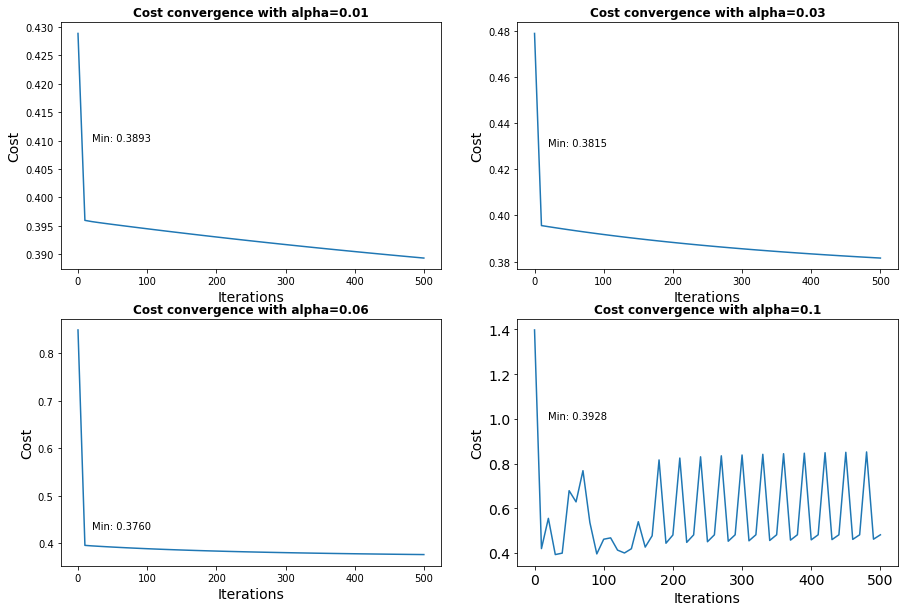

In [16]:
x01 = [i*10 for i, j in enumerate(costs01)]
y01 = [j for i, j in enumerate(costs01)]

x03 = [i*10 for i, j in enumerate(costs03)]
y03 = [j for i, j in enumerate(costs03)]

x06 = [i*10 for i, j in enumerate(costs06)]
y06 = [j for i, j in enumerate(costs06)]

x1 = [i*10 for i, j in enumerate(costs1)]
y1 = [j for i, j in enumerate(costs1)]

titles= ["Cost convergence with alpha=0.01", "Cost convergence with alpha=0.03", 
         "Cost convergence with alpha=0.06", "Cost convergence with alpha=0.1"]


axs = vis.createPlot(r=2,c=2,title=titles, figsize=[15,10], xlabel="Iterations", ylabel='Cost', sharey=False,
                    title_font=12)

plt.sca(axs[0])
sb.lineplot(x=x01,y=y01)
plt.text(20,0.41,"Min: {:.4f}".format(np.min(costs01)));

plt.sca(axs[1])
sb.lineplot(x=x03,y=y03)
plt.text(20,0.43,"Min: {:.4f}".format(np.min(costs03)));

plt.sca(axs[2])
sb.lineplot(x=x06,y=y06)
plt.text(20,0.43,"Min: {:.4f}".format(np.min(costs06)));

plt.sca(axs[3])
sb.lineplot(x=x1,y=y1)
plt.text(20,1.0,"Min: {:.4f}".format(np.min(costs1)));

#### Performance
* $\alpha = 0.1$ failed to converge
* $\alpha = 0.01$, $\alpha = 0.03$ are not fully converged after 500 iterations
* $\alpha = 0.06$ appears to be almost fully converged after 500 iterations
* The computations executed in an average of 30 seconds whilst tracking the cost to generate the plots.
*** 
Lets reassess learning rate 0.03 and 0.06 using 1000 iterations

In [17]:
%%time
theta_opt03_1000, costs03_1000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=1000)

CPU times: user 48.6 s, sys: 3.99 ms, total: 48.6 s
Wall time: 12.1 s


In [18]:
%%time
theta_opt06_1000, costs06_1000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.06, track=True, iters=1000)

CPU times: user 49.2 s, sys: 12 ms, total: 49.2 s
Wall time: 12.3 s


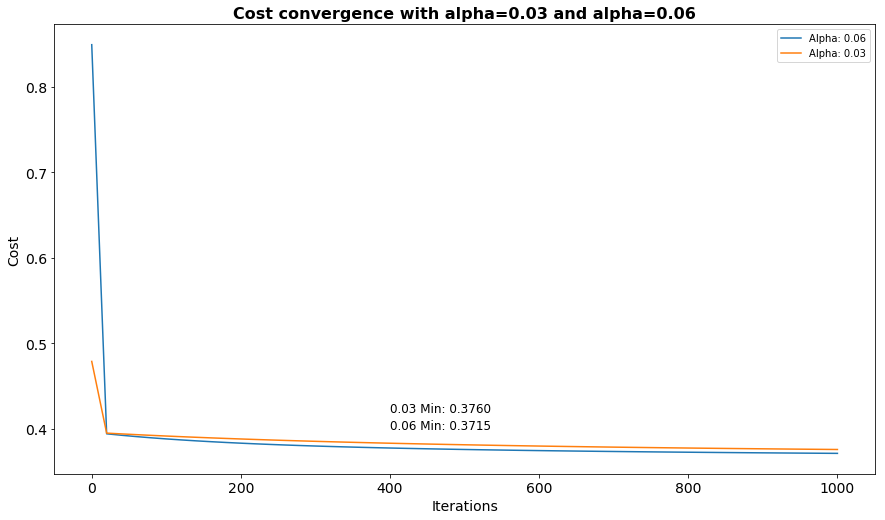

In [20]:
x03 = [i*20 for i, j in enumerate(costs03_1000)]
y03 = [j for i, j in enumerate(costs03_1000)]

x06 = [i*20 for i, j in enumerate(costs06_1000)]
y06 = [j for i, j in enumerate(costs06_1000)]

titles= ["Cost convergence with alpha=0.03 and alpha=0.06"]

axs = vis.createPlot(1,1,title=titles, xlabel="Iterations", ylabel='Cost', sharey=True)

sb.lineplot(x=x06,y=y06)
sb.lineplot(x=x03,y=y03)
plt.text(400,0.40,"0.06 Min: {:.4f}".format(np.min(costs06_1000)), fontsize=12);
plt.text(400,0.42,"0.03 Min: {:.4f}".format(np.min(costs03_1000)), fontsize=12);

import matplotlib.lines as mlines

c=sb.color_palette()

l0 = mlines.Line2D([],[], linestyle='-', color=c[0])
l1 = mlines.Line2D([],[], linestyle='-', color=c[1])

plt.legend((l0,l1),('Alpha: 0.06', 'Alpha: 0.03'));

#### Performance
* Both values of $\alpha$ appear to be converging toward a minimum cost ~0.37
* The same optimisation can be achieve with a learning rate $\alpha$ of 0.06 in half as many iterations than when using a learning rate $\alpha$ of 0.03, therefore we'll use $\alpha = 0.06$ for any further tuning.
*** 
### Model Prediction
We can now use our otpimised theta parameter to make predictions for indiviudal users and assess the models performance. Initially, we'll use prediction accuracy as our performance metric. 

We make use of the `sigmoid()`, `predict()` and `predictAccuracy()` functions defined below.

In [21]:
def sigmoid(X, theta):
    '''
    Returns the sigmoid of  theta.T.X
    Precondition: if X is (m x n), theta should be (n x i)
    '''
    return 1/(1+np.exp(-np.dot(X,theta)))

def predict(X, theta, threshold=0.5):
    '''Returns absolute predictions for all entries in X'''
    predictions = sigmoid(X, theta)
    return (predictions >= threshold).astype(int)

def predictAccuracy(predictions, y, pcnt=True):
    '''Returns prediction accuracy as percentage if pcnt==True, otherwise returns proportion.
    Precondition: len(predictions) ==  len(y)'''
    if pcnt:
        return "{:.2f}%".format(100*float((predictions == y).mean()))
    else:
        return (predictions == y).mean()

In [22]:
# Set optimum theta
theta_opt = theta_opt06_1000

# Predictions with theta optimised with 2000 iterations
predict_train = mod.predict(X_train, theta_opt)
predict_test = mod.predict(X_test, theta_opt)

print("train:", mod.predictAccuracy(predict_train, y_train), 
          "test:", mod.predictAccuracy(predict_test, y_test))

print("Convertions predicted:", predict_train.sum())

train: 88.02% test: 88.09%
Convertions predicted: 0


Initially it seems that we have a good train and test accuracy of 88%, however, the model has failed to predict any positive conversions at all. We discovered in the A/B investigation that 12% of the total sample converted, therefore predicting all negative cases gives us the 88% accuracy seen here. Lets us the $F_1$ score as an alternative metric.

$$Precision (P) = \frac{True Positives}{True Positives + False Positives}$$

$$Recall (R) = \frac{True Positives}{True Positives + False Negatives}$$

$$F_1 = 2\frac{PR}{P+R}$$

Because the model predicts no positive results, we have an $F_1$ score of zero. We need to optimise the prediction threshold since there are no examples with a sigmoid value greater than 0.5.

In [23]:
def precision(predictions, y):
    '''
    Calculate model precision.
    '''
    true_pos = ((predictions == 1) & (y == 1)).sum()
    false_pos = ((predictions == 1) & (y == 0)).sum()

    return true_pos/(true_pos+false_pos)

def recall(predictions, y):
    '''
    Calculate model precision.
    '''
    true_pos = ((predictions == 1) & (y == 1)).sum()
    false_neg = ((predictions == 0) & (y == 1)).sum()

    return true_pos/(true_pos+false_neg)

def f1score(predictions, y):
    '''
    Calculates F1 score as a prediction metric
    '''
    p = precision(predictions, y)
    r = recall(predictions, y)

    return (2*p*r)/(p + r)

In [24]:
print("Conversion Probability:\n", "Min:", "{:.4f}\n".format(mod.sigmoid(X_train, theta_opt).min()), 
      "Max:", "{:.4f}".format(mod.sigmoid(X_train, theta_opt).max()))

Conversion Probability:
 Min: 0.0665
 Max: 0.2519


The maximum probability of conversion as predicted by the model is 25.18% which is very low for this classification problem. We need to identify a classifier threshold which gives the best model performance.

/home/ding/coding/DAND/AB_Test/features/model.py:61: RuntimeWarning: invalid value encountered in long_scalars
  return true_pos/(true_pos+false_pos)


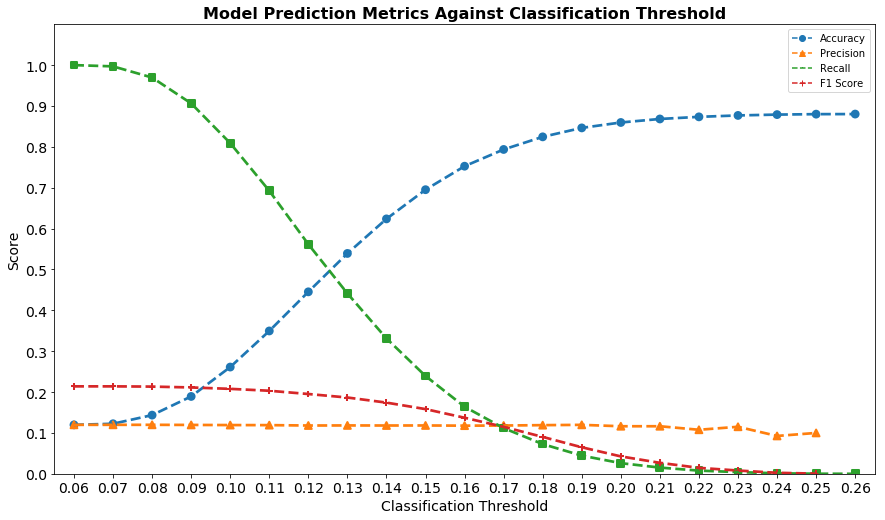

In [25]:
thresholds = np.arange(0.06,0.27,0.01)
labels = ["{:.2f}".format(i) for i in thresholds]

accuracies = [mod.predictAccuracy(mod.predict(X_train, theta_opt, i), y_train, pcnt=False) for i in thresholds]
precisions = [mod.precision(mod.predict(X_train, theta_opt, i), y_train) for i in thresholds]
recalls = [mod.recall(mod.predict(X_train, theta_opt, i), y_train) for i in thresholds]
f1s = [mod.f1score(mod.predict(X_train, theta_opt, i), y_train) for i in thresholds]

c=sb.color_palette()

vis.createPlot(ylabel="Score", xlabel="Classification Threshold");
sb.pointplot(x=thresholds, y=accuracies, linestyles='--', color=c[0], markers='o')
sb.pointplot(x=thresholds, y=precisions, linestyles='--', color=c[1], markers='^')
sb.pointplot(x=thresholds, y=recalls, linestyles='--', color=c[2], markers=',')
sb.pointplot(x=thresholds, y=f1s, linestyles='--', color=c[3], markers='+')

l0 = mlines.Line2D([],[], linestyle='--', color=c[0], marker='o')
l1 = mlines.Line2D([],[], linestyle='--', color=c[1], marker='^')
l2 = mlines.Line2D([],[], linestyle='--', color=c[2], marker=',')
l3 = mlines.Line2D([],[], linestyle='--', color=c[3], marker='+')


plt.legend((l0,l1,l2,l3), ("Accuracy","Precision", "Recall", "F1 Score"));

locs, _ = plt.xticks()
plt.xticks(locs, labels);
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Model Prediction Metrics Against Classification Threshold", fontsize=16, fontweight='bold');
plt.ylim(0,1.1);

#### Interpretation
* The highest accuracy is achieved when the model predicts **all** users do not convert
* The highest recall is achieved when the model predicts **all** users do convert
* The model precision remains fairly constant across the span of sigmoid thresholds
* The $F_1$ score starts to trend toward zero whent he sigmoid threshold is 0.12.

Finding the optimum balance of model performance depends on the business priorities. If the model is used for identifying the users who are most likely to make a purchase for marketing purposes, reducing the number of false negative predictions would probably be beneficial, therefore maximising recall would be sensible. Maximum recall is achieved when **all** users are predicted to make a purchase which is clearly not practical. A 50:50 balance between recall and model accuracy occurs when the sigmoid threshold is 0.125. At this point, the $F_1$ score has not deteriorated much either, therefore we'll select this value as our prediction threshold. 
***
Lets now test our optimised parameters on the test set to measure performance.

In [26]:
# Predictions with otpimised theta and threshold
predict_train = mod.predict(X_train, theta_opt, threshold=0.125)
predict_test = mod.predict(X_test, theta_opt, threshold=0.125)

f1_train = mod.f1score(predict_train, y_train)
f1_test = mod.f1score(predict_test, y_test)

train_acc = mod.predictAccuracy(predict_train, y_train)
test_acc = mod.predictAccuracy(predict_test, y_test)

print("Training Accuracy:{},\n F1 Score:{:.4f}\n".format(train_acc, f1_train))
print("Test Accuracy:{},\n F1 Score:{:.4f}".format(test_acc, f1_test))

Training Accuracy:49.23%,
 F1 Score:0.1914

Test Accuracy:49.64%,
 F1 Score:0.1934


The prediction accuracy on the test set is marginally higher than the training set. This indicates that the model is not overfitting the data so we do not need to add regularisation to our model. Lets view the distribution for the conversion probabilities of individual users.

/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


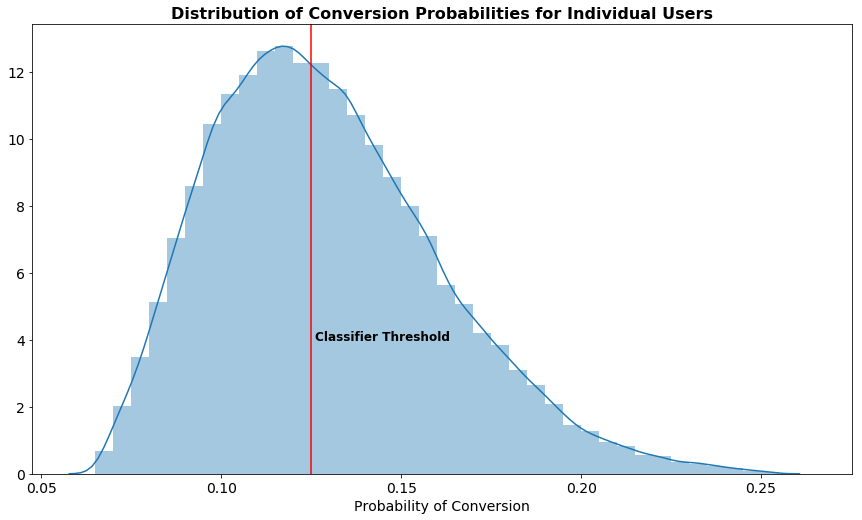

In [28]:
predictions = mod.sigmoid(X_train, theta_opt)
bins = np.arange(0.06,0.27,0.005)

vis.createPlot(xlabel="Probability of Conversion");
sb.distplot(predictions, bins=bins);
plt.title("Distribution of Conversion Probabilities for Individual Users", fontsize=16, fontweight='bold');
plt.axvline(x=0.125, color='r');
plt.text(0.126, 4, "Classifier Threshold", fontsize=12, fontweight='bold');

#### Interpretation
* All values are less than 0.5, indicating that the model is predicting user conversion with low confidence.
* The model predicts approximatly 50% of the users to convert when using a threshold of 0.125. 

We know from our previous assessments that 12% of users within the sample actually convert so the model seems to be overpredicting. The test accuracy of the model is 49.6% so we expected there to be the same number of correct and incorrect predictions to the left and right of the threshold. This is an indication that the model is not performing well at predicting user conversion. 
***
### ROC Curve Analysis
We can assess model performance more rigorously by plotting a Receiving Operator Characteristic (ROC) curve and measuring the Area Under Curver (AUC) metric.

* $AUC = 1$ corresponds to perfect prediction. That is a true positive rate of 100% and false positive rate of 0%
* $AUC > 0.5$ the algorithm correctly predicts more than half the cases.
* $AUC = 0.5$ the model performamce is equivalent to randomness. It can be said that the model has no skill.
* $AUC < 0.5$ there is enough data to predict but the algorithm predicts the opposite case more often.

To generate a ROC curve, we plot the *true positive rate* (otherwise known as recall or sensitivity) against the *false positive rate*. 

$$True Positive Rate (Recall) = \frac{True Positives}{True Positives + False Negatives}$$<br>
$$False Positive Rate = \frac{False Positives}{False Positives + True Negatives}$$

In [44]:
def plotROC(X, y, theta, thresholds, **kwargs):
    '''Plots the ROC (Received Operator Characterstic) curve for X.'''
    tpr, fpr = [], []
    for t in thresholds:
        predictions = mod.predict(X, theta, threshold=t)
        cnf = mod.confMatrix(predictions, y)

        tpr.append(cnf[1][1]/(cnf[1][1]+cnf[1][0]))
        fpr.append(cnf[0][1]/(cnf[0][1]+cnf[0][0]))

    createPlot(title=["Receiving Operator Characterstic Curve"],
                xlabel='False Positive Rate',
                ylabel='True Positive Rate', **kwargs);

    plt.plot(fpr,tpr);
    plt.xlim(0,1);
    plt.ylim(0,1);

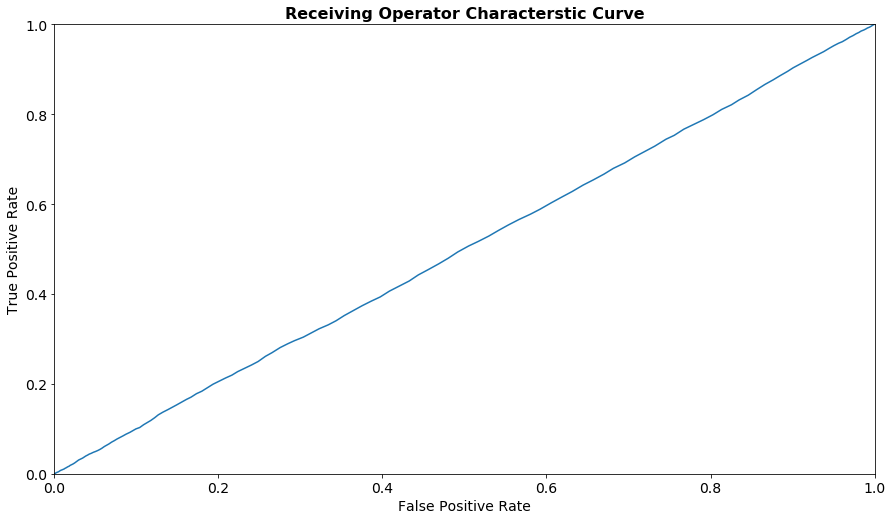

In [47]:
# Thresholds across the full range of predicted probabilities
thresholds = np.arange(0.06,0.27,0.001)

vis.plotROC(X_test, y_test, theta_opt, thresholds)

The ROC plot forms a straight line where true positive rate is equal to the false positive rate, therefore the Area Under Curve (AUC) is 0.5. This indicates that our model is not performing and predicts conversion randomly. 
***
## Compare With Sci-Kit Learn Model
Finally, we will repeat this analysis making use of the Sci-Kit Learn library.

/home/ding/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


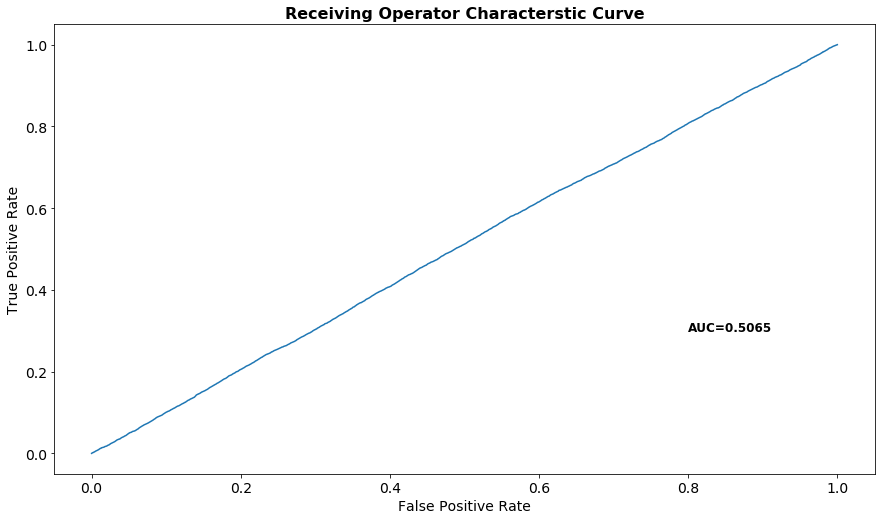

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Instantiate and fit model
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

# Plot ROC curve
raw_predictions = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  raw_predictions)
auc = metrics.roc_auc_score(y_test, raw_predictions)

vis.createPlot(title=["Receiving Operator Characterstic Curve"], xlabel='False Positive Rate',
              ylabel='True Positive Rate');    

plt.plot(fpr,tpr);
plt.text(0.8,0.3,"AUC={:.4f}".format(auc), fontsize=12, fontweight='bold');

The observed ROC curve is almost identicle to the ROC curve generated from our custom logistic regression model, with an AUC value equal to 0.51.
***
## Conclusions
* We succesfully built and optimised logistic regression models using numpy and sci-kit learn libraries.
* Optimising theta with a learning rate $\alpha$ of 0.06 enabled gradient descent to converge.
* A classification threshold of 0.125 provided a prediction accuracy and recall of 50%. The maximum prediction accuracy of 88% was achieved when all users were predicted not to make a purchase, which is not useful in practice.
* Both models generated a linear ROC curve with AUC value close to 0.5, meaning the model was inneffective for predictig the user conversion.

The A/B test data needs more features to be able to accurately predict the probability of individual user conversion. These could relate to account information, such as:

* Number of site visits
* Amount of time spent on the website
* Length of time the account has been active
* Total amount spent on the website
* Number of previous purchases made.